# Ejercicio análisis time series
Para este ejercicio vas a trabajar con el histórico de valores en bolsa de una empresa que se dedica a vender muebles. Se pide
1. Importa los datos 'df_furniture.csv'
2. Trata la fecha como texto. Crea una columna para el año, mes y dia, y a partir de esas columnas crea la de fecha, en formato datetime de pandas
3. ¿De qué fecha a qué fecha va el histórico?
4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?
5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?
6. Parece que hay una tendencia, pero no se aprecia bien con tanto pico en la serie. ¿Conoces algún método para representar mejor la tendencia?
7. Estaría bien visualizar todos los componentes de la serie temporal por separado
8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional
9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuéstralo mediante una matriz de correlación. ¿Esto es bueno para los modelos?
10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?
11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## 1. Cargamos los datos

In [2]:
df = pd.read_csv('data/df_furniture.csv')

In [3]:
df.head()

,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


## 2. Tratar la fecha como texto y parsear

In [4]:
df[['year','month','day']] = df['Month'].str.split('-',expand=True)

In [5]:
df.head()

,Month,furniture_price_adjusted,year,month,day
0,1992-01-01,2073.432724,1992,01,01
1,1992-02-01,2114.485812,1992,02,01
2,1992-03-01,2260.570891,1992,03,01
3,1992-04-01,2255.103236,1992,04,01
4,1992-05-01,2331.414618,1992,05,01


In [7]:
df['Fecha'] = pd.to_datetime(df[['year', 'month', 'day']])

In [8]:
df.head(5)

,Month,furniture_price_adjusted,year,month,day,Fecha
0,1992-01-01,2073.432724,1992,01,01,1992-01-01
1,1992-02-01,2114.485812,1992,02,01,1992-02-01
2,1992-03-01,2260.570891,1992,03,01,1992-03-01
3,1992-04-01,2255.103236,1992,04,01,1992-04-01
4,1992-05-01,2331.414618,1992,05,01,1992-05-01


## 3. ¿De qué fecha a qué fecha va el histórico?

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Month                     326 non-null    object        
 1   furniture_price_adjusted  331 non-null    float64       
 2   year                      326 non-null    object        
 3   month                     326 non-null    object        
 4   day                       326 non-null    object        
 5   Fecha                     326 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 15.6+ KB


In [10]:
df['Fecha'].describe()

count                              326
mean     2005-11-30 13:23:55.582822144
min                1992-01-01 00:00:00
25%                1999-03-08 18:00:00
50%                2005-12-16 12:00:00
75%                2012-09-23 12:00:00
max                2019-07-01 00:00:00
Name: Fecha, dtype: object

## 4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?

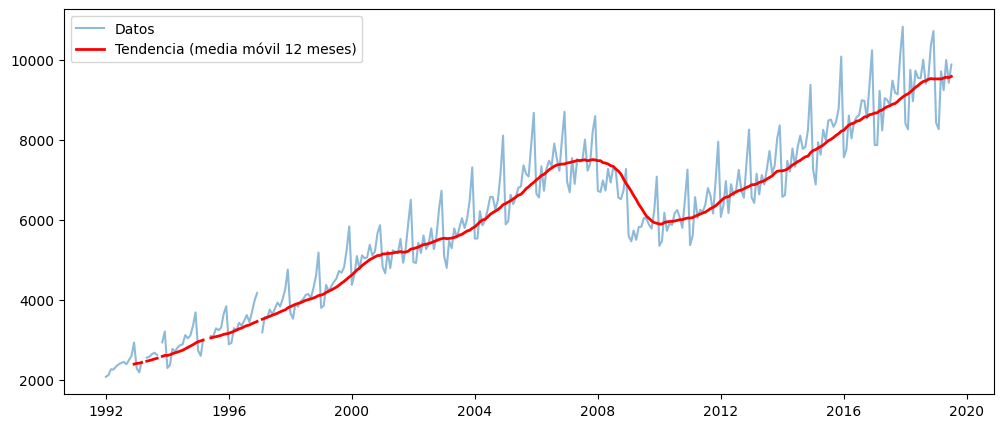

In [14]:
# Visualizar tendencia
plt.figure(figsize=(12,5))
plt.plot(df['Fecha'], df['furniture_price_adjusted'], alpha=0.5, label='Datos')
plt.plot(df['Fecha'], df['furniture_price_adjusted'].rolling(window=12).mean(), 
         color='red', linewidth=2, label='Tendencia (media móvil 12 meses)')
plt.legend()

En términos generales la tendencia es alcista, aunque hubo una bajada entre el 2008 y 2012. También se puede ver una estacionalidad todos los años, siempre hay una subida bastante pronunciada cada año. 

## 5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?

Correlación temporal: 0.928


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

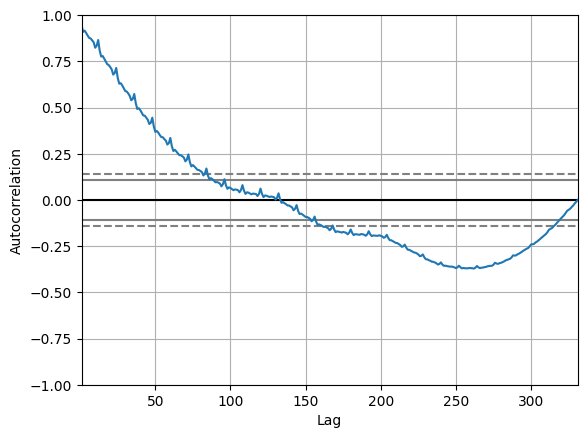

In [15]:
# Tendencia - Correlación con tiempo
from scipy.stats import pearsonr
tiempo = range(len(df))
correlacion, p_valor = pearsonr(tiempo, df['furniture_price_adjusted'])
print(f"Correlación temporal: {correlacion:.3f}")  # >0.3 sugiere tendencia

# Estacionalidad - Autocorrelación
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['furniture_price_adjusted'])  # Picos en lag 12, 24 = estacionalidad anual

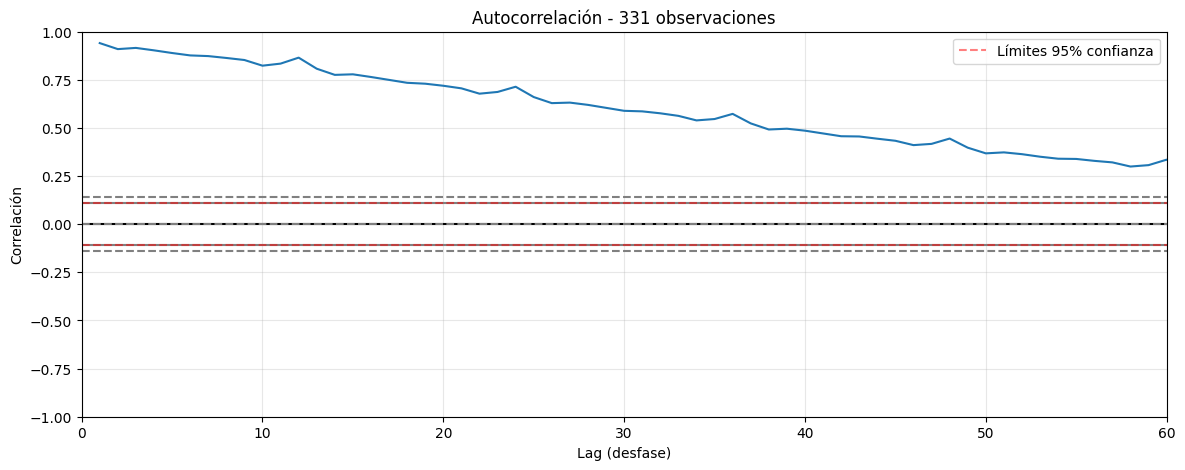

<Figure size 1400x500 with 0 Axes>

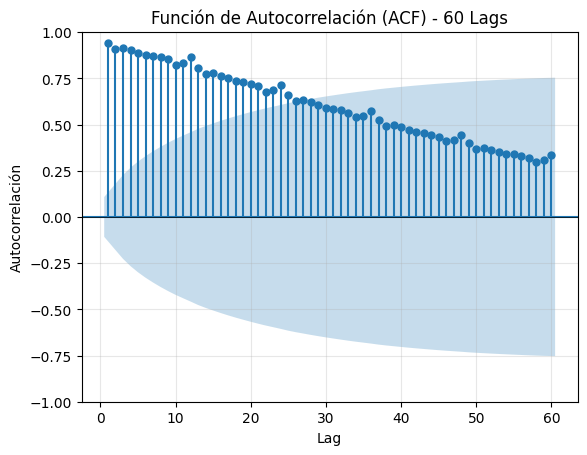

In [19]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

# Configurar tamaño
plt.figure(figsize=(14, 5))

# OPCIÓN 1: Gráfica simple con pandas (hasta 60 lags)
autocorrelation_plot(df['furniture_price_adjusted'])
plt.xlim([0, 60])  # Limitar a 60 lags
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(df)), color='red', linestyle='--', alpha=0.5, label='Límites 95% confianza')
plt.axhline(y=1.96/np.sqrt(len(df)), color='red', linestyle='--', alpha=0.5)
plt.title(f'Autocorrelación - {len(df)} observaciones')
plt.xlabel('Lag (desfase)')
plt.ylabel('Correlación')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# OPCIÓN 2: Gráfica más detallada con statsmodels (RECOMENDADA)
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

plt.figure(figsize=(14, 5))
plot_acf(df['furniture_price_adjusted'].dropna(), lags=60, alpha=0.05, 
         title=f'Función de Autocorrelación (ACF) - 60 Lags', 
         zero=False, bartlett_confint=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.show()

## 6. ¿Conoces algún método para representar mejor la tendencia?

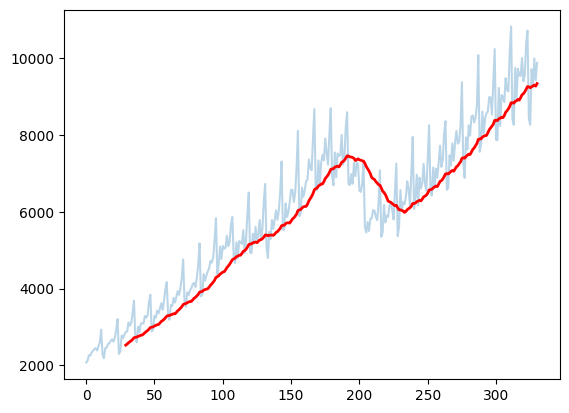

In [20]:
# Ventanas comunes: 7(días), 30(días), 12(meses)
df['MA_30'] = df['furniture_price_adjusted'].rolling(window=30).mean()
plt.plot(df['furniture_price_adjusted'], alpha=0.3, label='Original')
plt.plot(df['MA_30'], color='red', linewidth=2, label='Media Móvil 30 días')

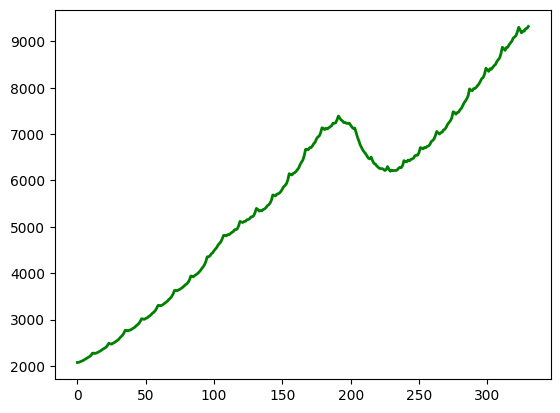

In [22]:
#(Exponential Smoothing)
df['EMA_30'] = df['furniture_price_adjusted'].ewm(span=30, adjust=False).mean()
plt.plot(df['EMA_30'], color='green', linewidth=2, label='Suavizado Exponencial')

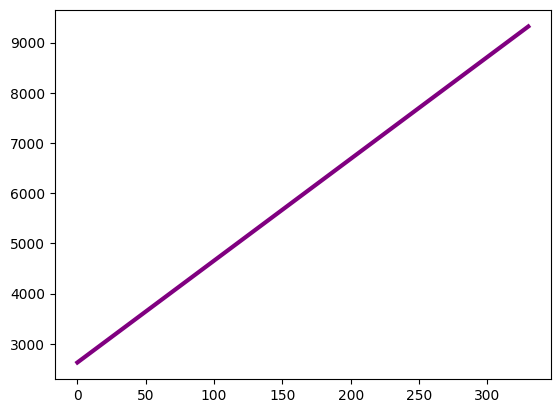

In [ ]:
#Regresión Lineal sobre el tiempo
import numpy as np
from scipy.stats import linregress

# X = tiempo (días desde inicio), Y = valores
tiempo = np.arange(len(df))
pendiente, intercepto, _, _, _ = linregress(tiempo, df['furniture_price_adjusted'])
df['Tendencia_Lineal'] = intercepto + pendiente * tiempo

plt.plot(df['Tendencia_Lineal'], color='purple', linewidth=3, label='Tendencia Lineal')

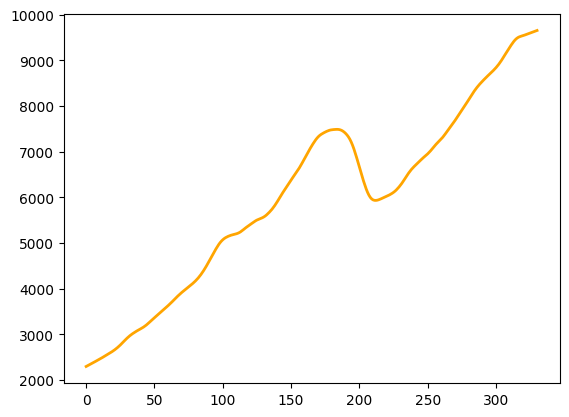

In [25]:
from statsmodels.tsa.seasonal import STL

stl = STL(df['furniture_price_adjusted'], period=12)  # period=12 para mensual
result = stl.fit()
df['Tendencia_STL'] = result.trend

plt.plot(df['Tendencia_STL'], color='orange', linewidth=2, label='Tendencia STL')

In [26]:
# Tendencia simple y lineal → Regresión lineal

# Tendencia cambiante con ruido → Media móvil o suavizado exponencial

# Datos económicos/cíclicos → Filtro Hodrick-Prescott

# Análisis estacional completo → Descomposición STL

# Visualización rápida → Media móvil con ventana adecuada

# Regla práctica: Empieza con media móvil de 30 periodos, luego prueba STL si necesitas más detalle

## 7. Estaría bien visualizar todos los componentes de la serie temporal por separado

In [30]:
from statsmodels.tsa.seasonal import STL

stl = STL(df['furniture_price_adjusted'], 
          period=12,       # Estacionalidad anual
          seasonal=13,     # Longitud del filtro estacional (debe ser impar)
          trend=21,        # Longitud del filtro de tendencia
          robust=True)     # Reduce efecto de outliers

resultado_stl = stl.fit()

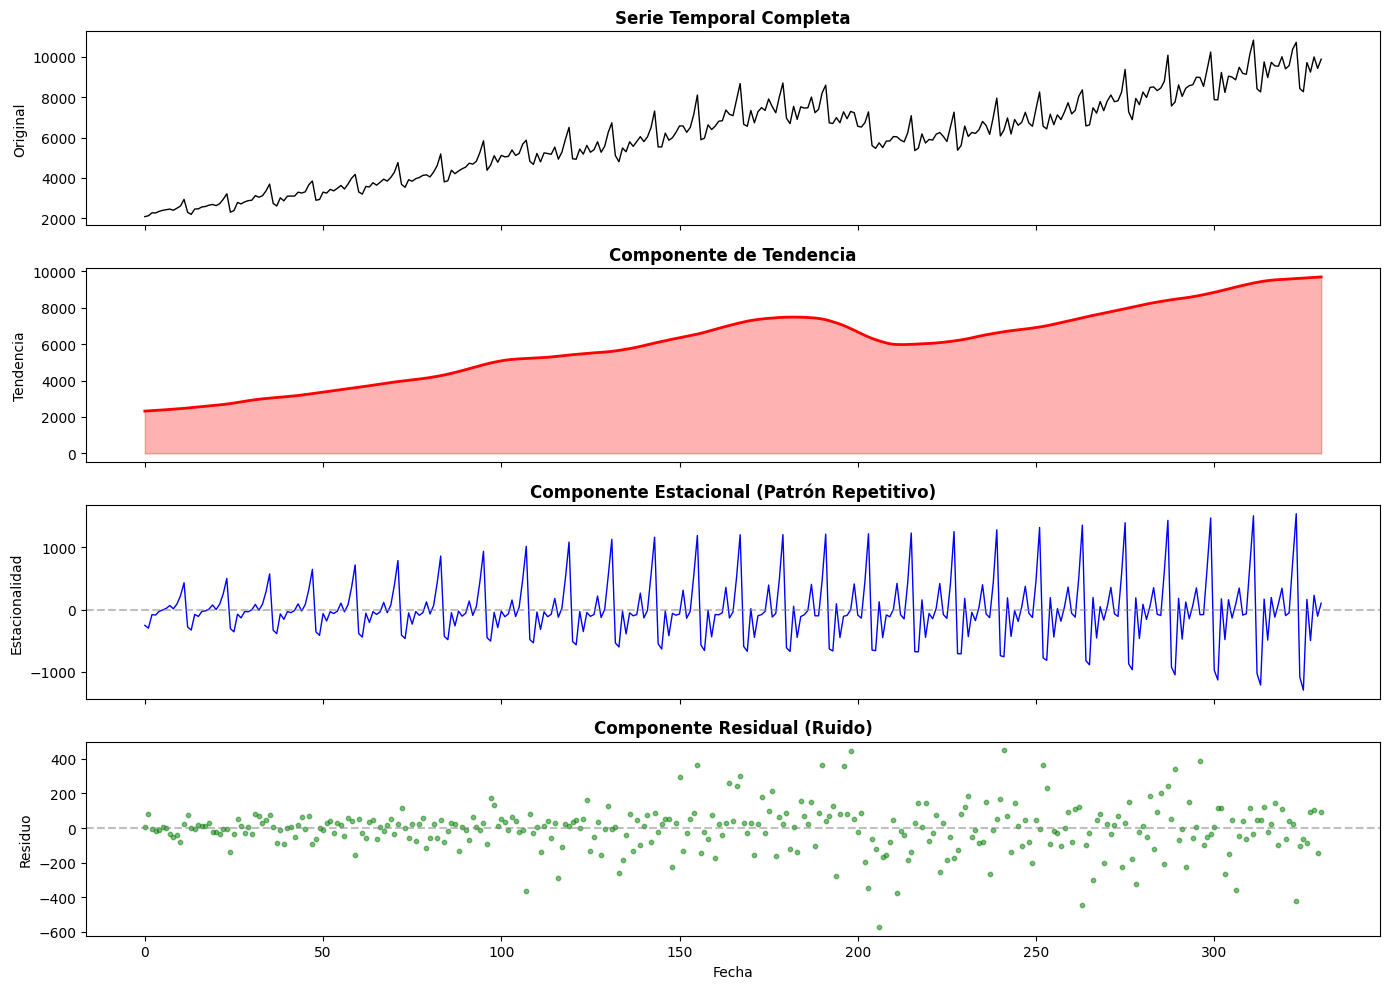

In [29]:
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# 1. Serie Original
axes[0].plot(df.index, df['furniture_price_adjusted'], color='black', linewidth=1)
axes[0].set_ylabel('Original')
axes[0].set_title('Serie Temporal Completa', fontweight='bold')

# 2. Tendencia
axes[1].plot(df.index, resultado_stl.trend, color='red', linewidth=2)
axes[1].fill_between(df.index, resultado_stl.trend, alpha=0.3, color='red')
axes[1].set_ylabel('Tendencia')
axes[1].set_title('Componente de Tendencia', fontweight='bold')

# 3. Estacionalidad
axes[2].plot(df.index, resultado_stl.seasonal, color='blue', linewidth=1)
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_ylabel('Estacionalidad')
axes[2].set_title('Componente Estacional (Patrón Repetitivo)', fontweight='bold')

# 4. Residuo (Ruido)
axes[3].scatter(df.index, resultado_stl.resid, color='green', s=10, alpha=0.5)
axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[3].set_ylabel('Residuo')
axes[3].set_xlabel('Fecha')
axes[3].set_title('Componente Residual (Ruido)', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional

<Figure size 1400x500 with 0 Axes>

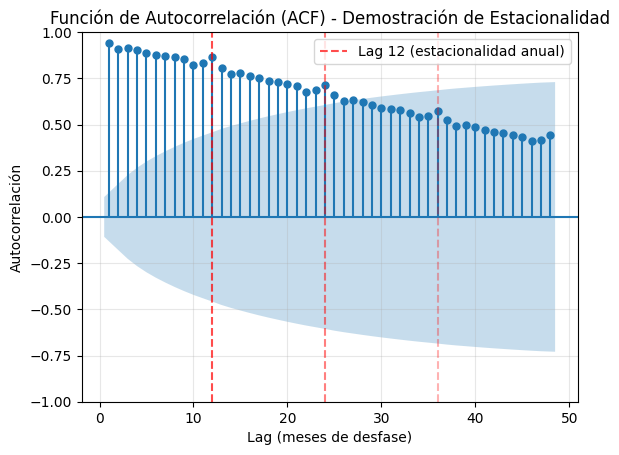

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plot_acf(df['furniture_price_adjusted'].dropna(), lags=48, alpha=0.05, 
         title='Función de Autocorrelación (ACF) - Demostración de Estacionalidad',
         zero=False, bartlett_confint=True)
plt.axvline(x=12, color='red', linestyle='--', alpha=0.7, label='Lag 12 (estacionalidad anual)')
plt.axvline(x=24, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=36, color='red', linestyle='--', alpha=0.3)
plt.xlabel('Lag (meses de desfase)')
plt.ylabel('Autocorrelación')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. ¿Qué dependencia tiene cada instante de sus últimos 5 lags? Demuéstralo mediante una matriz de correlación.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Crear DataFrame con los lags
df_lags = pd.DataFrame({
    't': df['furniture_price_adjusted'],            # Valor actual
    't-1': df['furniture_price_adjusted'].shift(1), # 1 periodo atrás
    't-2': df['furniture_price_adjusted'].shift(2), # 2 periodos atrás
    't-3': df['furniture_price_adjusted'].shift(3), # 3 periodos atrás
    't-4': df['furniture_price_adjusted'].shift(4), # 4 periodos atrás
    't-5': df['furniture_price_adjusted'].shift(5)  # 5 periodos atrás
})

# Eliminar filas con NaN (primeras 5 filas sin lags completos)
df_lags_clean = df_lags.dropna()

# Calcular matriz de correlación
corr_matrix = df_lags_clean.corr()

print("📊 MATRIZ DE CORRELACIÓN (últimos 5 lags):")
print(corr_matrix.round(3))

📊 MATRIZ DE CORRELACIÓN (últimos 5 lags):
         t    t-1    t-2    t-3    t-4    t-5
t    1.000  0.949  0.926  0.944  0.940  0.936
t-1  0.949  1.000  0.949  0.926  0.944  0.940
t-2  0.926  0.949  1.000  0.949  0.926  0.944
t-3  0.944  0.926  0.949  1.000  0.949  0.926
t-4  0.940  0.944  0.926  0.949  1.000  0.950
t-5  0.936  0.940  0.944  0.926  0.950  1.000


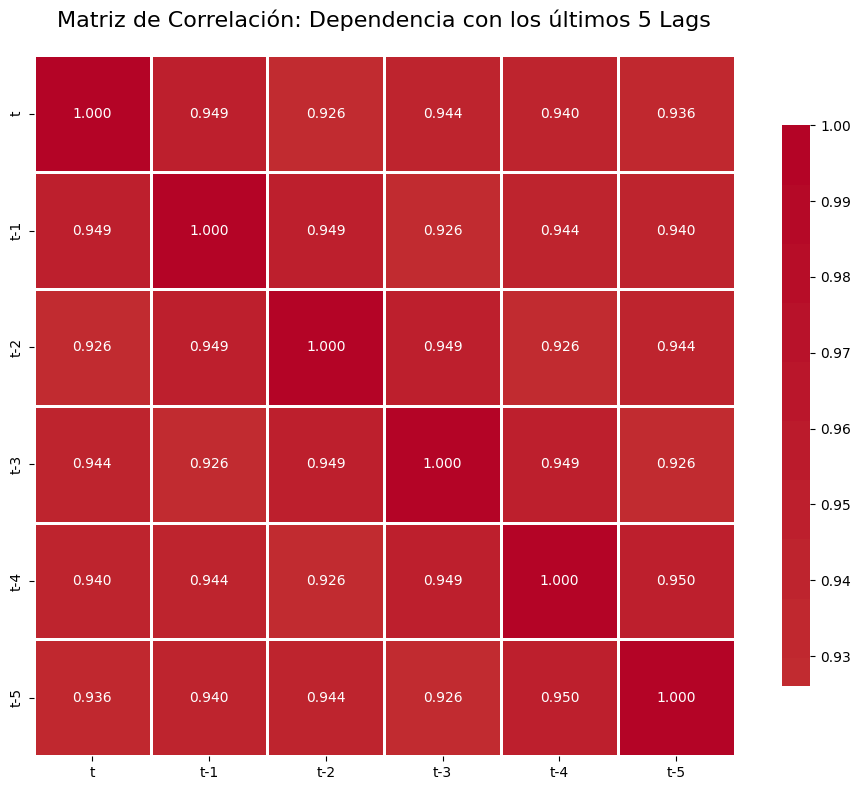

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.3f',
            linewidths=1,
            square=True,
            cbar_kws={"shrink": 0.8})

plt.title('Matriz de Correlación: Dependencia con los últimos 5 Lags', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## 10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

Lag  3: autocorrelación = -0.002
Lag  4: autocorrelación = -0.034
Lag  6: autocorrelación = -0.221
Lag 12: autocorrelación = 0.952
Lag 24: autocorrelación = 0.899


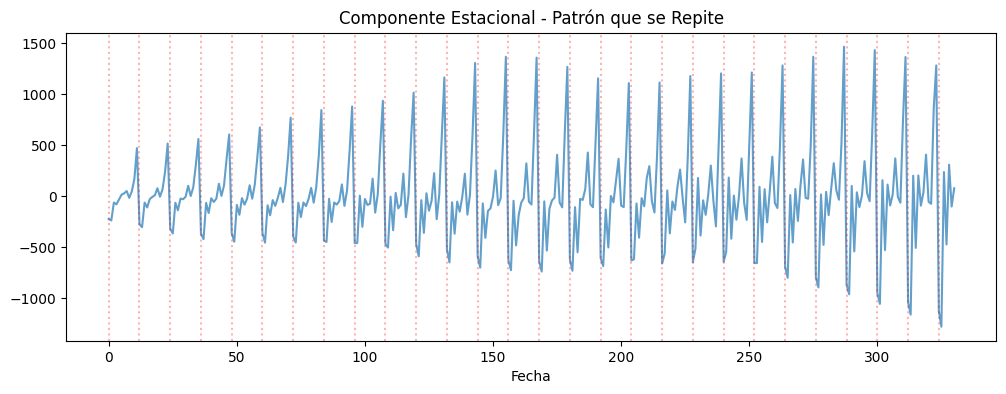

In [36]:
# 1. Extraer componente estacional
stl = STL(df['furniture_price_adjusted'], period=12)  # Asumimos 12 meses
result = stl.fit()
estacionalidad = result.seasonal.dropna()

# 2. Autocorrelación para encontrar período exacto
from statsmodels.tsa.stattools import acf
autocorr = acf(estacionalidad, nlags=36, fft=False)

# Encontrar pico después de lag 0
lags_posibles = [3, 4, 6, 12, 24]  # Posibles períodos
for lag in lags_posibles:
    if lag < len(autocorr):
        print(f"Lag {lag:2d}: autocorrelación = {autocorr[lag]:.3f}")

# 3. Gráfico de verificación
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(estacionalidad.index, estacionalidad.values, alpha=0.7)
plt.title('Componente Estacional - Patrón que se Repite')
plt.xlabel('Fecha')

# Marcar cada período para visualizar repetición
periodo = 12  # Cambia según lo que encuentres
for i in range(0, len(estacionalidad), periodo):
    plt.axvline(x=estacionalidad.index[i], color='red', linestyle=':', alpha=0.3)
    
plt.show()

## 11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?